Import useful libraries

In [3]:
import numpy as np
from matplotlib import pyplot as plt 
from pandas import read_csv
import sys
import os
from matplotlib import rcParams
import toml

%load_ext autoreload
%autoreload 2

Matplotlib is building the font cache; this may take a moment.


# Block spin analysis

In [4]:
from correlations import *
from read_in_data import *
from mass_fit import *
from mass_matteo import *
from functions import *

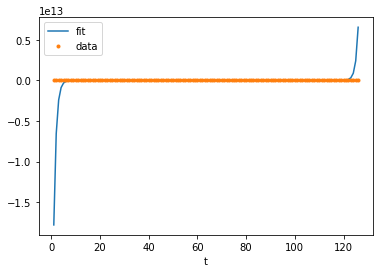

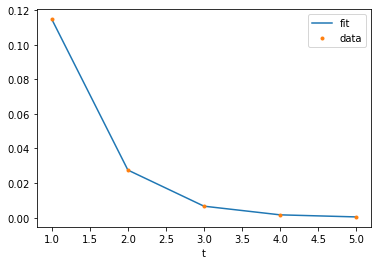

[(1.428825902544078, 0.4790990069085729)] 1.7630837118342122


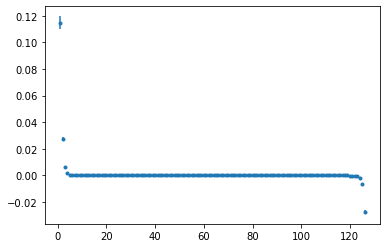

In [26]:
x = Dataset(128, 128)
x.add_data("./data/mass_extraction/conf3/" , ["langevin", "averageEpsilon"], 1)
print(x.m_q_phys, expectedM(0.7, 1.5/np.sqrt(2*0.18), x.phi[0][0], [0,0,0]))
plt.errorbar(range(1, x.Nt-1), x.correlator_f[0][0][1:x.Nt-1], x.correlator_f[0][1][1:x.Nt-1], fmt='.')
plt.show()

In [ ]:
plt.plot([8, 16, 32, 64], [0.620737, 0.623195, 0.623918, 0.624308], 'o--', markersize=4)
plt.fill([8, 8, 64, 64], [0.614, 0.616, 0.616, 0.614], color="green", label="HMC + pseudof. Timoteo")
plt.grid()
plt.xlabel("N", fontsize=14)
plt.ylabel(r"$\left\langle|\phi|\right\rangle$", fontsize=14)
ax = plt.gca()
ax.set_xticks([8, 16, 32, 64])
#ax.set_xticklabels(["8", "16", "32", "64"])
plt.savefig("timo_vol.pdf")


In [ ]:
dataset1 = Dataset(128, 128)
for i in range(1, 4):
    dataset1.add_data("./data/confs/conf" + str(i) + "/", ["langevin", "averageEpsilon"], 1)

# Magnetisation

In [1]:
plt.errorbar(dataset1.parameters, [v[0] for v in dataset1.phi], [v[1] for v in dataset1.phi], fmt='o--', markersize=4, label="Lang. + bilin. Matteo")
plt.errorbar([0.01], [0.625], [1e-3], fmt='o', label="Lang. + pseudof. Timoteo")
plt.grid()
plt.xscale('log')
plt.xlabel("dt", fontsize=14)
plt.ylabel(r"$\left\langle|\phi|\right\rangle$", fontsize=14)
plt.fill([1e-3, 1e-3, 5e-2, 5e-2], [0.614, 0.616, 0.616, 0.614], color="green", label="HMC + pseudof. Timoteo")
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig("timo.pdf")

NameError: name 'plt' is not defined

In [7]:
dataset1 = Dataset(64, 64)
dataset1.add_data("./data/confss/", ["langevin", "averageEpsilon"], 1)

OSError: /home/matteo/Downloads/ac/build/libac.so: cannot open shared object file: No such file or directory

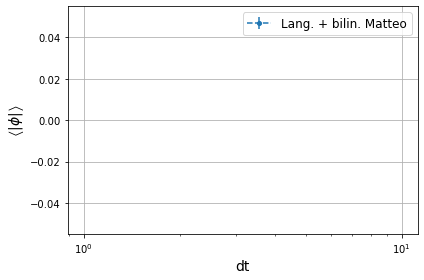

In [8]:
plt.errorbar(dataset1.parameters, [v[0] for v in dataset1.phi], [v[1] for v in dataset1.phi], fmt='o--', markersize=4, label="Lang. + bilin. Matteo")
plt.grid()
plt.xscale('log')
plt.xlabel("dt", fontsize=14)
plt.ylabel(r"$\left\langle|\phi|\right\rangle$", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()

# Susceptibility

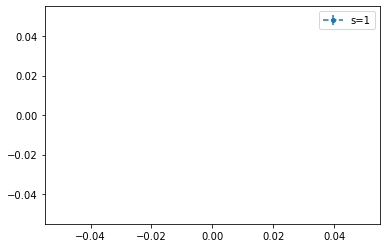

In [9]:
plt.errorbar(dataset1.parameters, [v[0] for v in dataset1.chi2], [v[1] for v in dataset1.chi2], fmt='o--', markersize=4, label='s=1')
plt.legend()
plt.show()

# Condensate

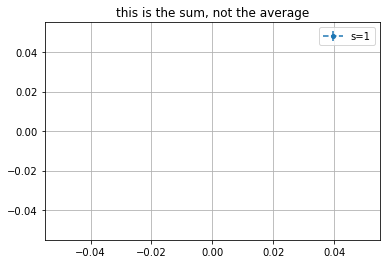

In [10]:
plt.errorbar(dataset1.parameters, [dataset1.Nx*dataset1.Nx*v[0] for v in dataset1.condensate], [dataset1.Nx*dataset1.Nx*v[1] for v in dataset1.condensate], fmt='o--', markersize=4, label='s=1')
plt.grid()
plt.legend()
plt.title("this is the sum, not the average")
plt.show()

# Physical quark mass

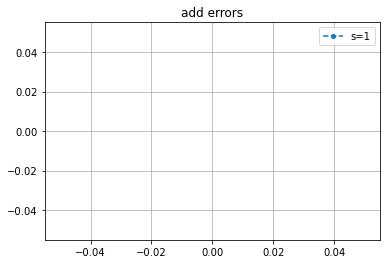

In [11]:
plt.plot(dataset1.parameters, [v[0] for v in dataset1.m_q_phys], 'o--', markersize=4, label='s=1')
plt.grid()
plt.legend()
plt.title("add errors")
plt.show()

# Renormalised boson mass

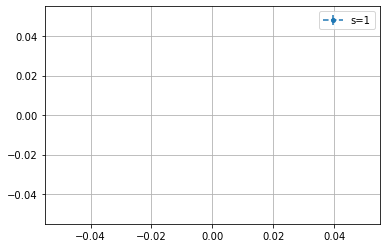

In [12]:
plt.errorbar(dataset1.parameters, [dataset1.Nx*v[0] for v in dataset1.m_phi_r], [dataset1.Nx*v[1] for v in dataset1.m_phi_r], fmt='o--', markersize=4, label='s=1')
plt.grid()
plt.legend()
plt.show()